In [326]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from nltk.corpus import stopwords
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

warnings.filterwarnings("ignore")

Custom functions

In [327]:
#1 Remove stop words from text
def remove_stops(text, filler=''):
    return filler.join([word.title() for word in str(text).lower().split() if word not in stopwords.words('english')])

#2 Plot function for value counts
def value_count_plots(dfs, columns, labels=[], size=[10, 10], ncols=3):

    if len(columns) % ncols != 0:
        nrows = len(columns) // ncols + 1
    else:
        nrows = len(columns) // ncols

    idx = 1
    plt.figure(figsize= size, layout='tight')   
    for col in columns:
        if idx == 3:
            ax.set_title('Value counts for object types')
        ax = plt.subplot(nrows, ncols, idx)
        if type(dfs) == list:
            for df, align, label in zip(dfs, ['edge', 'center'], labels):   # can best accomodate 2
                ax.barh(df[col].value_counts(normalize= True).index, 
                        df[col].value_counts(normalize= True).values, 
                        label=label, align=align)
                ax.set_xlabel(col)
        else:
            ax.barh(dfs[col].value_counts(normalize= True).index, 
            dfs[col].value_counts(normalize= True).values)
            ax.set_xlabel(col)
        idx += 1
        plt.legend()
    plt.show()

#4 Plot function for histogram
def histogram_plots(dfs, columns, labels=[], size=[10, 10], ncols=3):

    if len(columns) % ncols != 0:
        nrows = len(columns) // ncols + 1
    else:
        nrows = len(columns) // ncols

    idx = 1
    plt.figure(figsize= size, layout='tight')
    for col in columns:
        if idx == 3:
            ax.set_title('Histogram for numeric types')
        ax = plt.subplot(nrows, ncols, idx)
        if type(dfs) == list:
            for df, align, label in zip(dfs, ['left', 'right'], labels):
                ax.hist(df[col], align= align, label= label, density= True)
                ax.set_xlabel(col)
        else:
            ax.hist(dfs[col], density= True)
            ax.set_xlabel(col)
        idx += 1
        plt.legend()
    plt.show()

#5  Plot function for boxplots
def box_plots(df, num_cols, cat_cols=[], size=[10, 10], ncols= 3, vertical= True):

    if len(cat_cols)>0:     # numeric spread for each category value
        if len(cat_cols) % ncols != 0:
            nrows = len(cat_cols) // ncols + 1
        else:
            nrows = len(cat_cols) // ncols
        idx = 1
        plt.figure(figsize= size, layout='tight')
        for row in cat_cols:
            ax = plt.subplot(nrows, ncols, idx)
            for col in num_cols:
                if vertical:
                    ax.boxplot([df[df[row]==val][col] for val in df[row].unique()], label= col)
                    ax.set_xticks(np.arange(1, df[row].nunique() + 1), df[row][~df[row].isnull()].unique())
                    ax.set_xlabel(col)
                    ax.set_ylabel(row)
                else:
                    ax.boxplot([df[df[row]==val][col] for val in df[row].unique()], label= col, vert= False)
                    ax.set_yticks(np.arange(1, df[row].nunique() + 1), df[row][~df[row].isnull()].unique())
                    ax.set_xlabel(col)
                    ax.set_ylabel(row)
            idx += 1
            plt.legend()
        plt.show()
        
    else:       # numeric spread only
        if len(num_cols) % ncols != 0:
            nrows = len(num_cols) // ncols + 1
        else:
            nrows = len(num_cols) // ncols
        idx = 1
        plt.figure(figsize= size, layout='tight')
        for col in num_cols:
            ax = plt.subplot(nrows, ncols, idx)
            if vertical:
                ax.boxplot(df[col])
                ax.set_xlabel(col)
            else:
                ax.boxplot(df[col], vert= False)
                ax.set_xlabel(col)
            idx += 1
        plt.show()

#6 Store null columns in a dataframe
def fetch_nulls(df):
    nulls = df.isnull().sum()
    condition = df.isnull().sum() > 0

    df_nulls = pd.concat([df[nulls[condition].index].dtypes, (nulls[condition] / len(df) * 100).round(2)], axis=1).reset_index()
    df_nulls.columns = ['Column_name', 'dtype', 'percent_nulls']
    df_nulls.sort_values(by= 'percent_nulls', ascending= False)
    return df_nulls

def check_feature_importance(df, cols, target, class_names=[], max_depth=2, discrete_target= True):
    # Source data transform
    encoder = OrdinalEncoder()
    df = df.copy()
    df[df.columns[df[cols].dtypes=='O']] = encoder.fit_transform(df[df.columns[df[cols].dtypes=='O']])
    X = df.drop(columns=[target])
    y = df[target]
    if class_names:
        classes = class_names
    else:
        classes = df[target].unique().tolist()
    
    if discrete_target:
        dt = DecisionTreeClassifier(max_depth= max_depth)
        dt.fit(X, y)
    else:
        dt = DecisionTreeRegressor(max_depth= max_depth)
        dt.fit(X, y)        

    y_pred = dt.predict(X)
    if discrete_target:
        print('Model accuracy score = ',accuracy_score(y, y_pred))
        print('Confusion matrix: ')
        print(pd.DataFrame(confusion_matrix(y, y_pred), columns= classes, index= classes))        
    else:
        print('Model accuracy score = ',r2_score(y, y_pred))

    dt_features = pd.Series(dt.feature_importances_, index= X.columns)
    dt_features[dt_features != 0].sort_values().plot.barh()
    plt.title('Feature importance in Decision Tree')
    plt.show()

    return dt

## Load Data

In [328]:
ls = pd.read_csv("Leads.csv")
ls.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,...,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,...,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,...,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [329]:
ls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

Shortening column names by removing stopwords and joining with '_'

In [330]:
ls.columns = [remove_stops(text, '_') for text in ls.columns]

Prospect_ID and Lead_Number are unique keys for each sales prospect and can be dropped

In [331]:
ls.drop(columns=['Prospect_Id', 'Lead_Number'], inplace= True)

Shortening values of object type columns with long names

In [332]:
long_vals = ['Tags', 'Last_Activity', 'Lead_Quality', 'Last_Notable_Activity']
for col in long_vals:
    ls.loc[~ls[col].isnull(), col] = ls[~ls[col].isnull()][col].apply(lambda x: remove_stops(x, ' '))

In [333]:
ls[long_vals].head()

,Tags,Last_Activity,Lead_Quality,Last_Notable_Activity
0,Interested Courses,Page Visited Website,Low Relevance,Modified
1,Ringing,Email Opened,NaN,Email Opened
2,Revert Reading Email,Email Opened,Might,Email Opened
3,Ringing,Unreachable,Sure,Modified
4,Revert Reading Email,Converted Lead,Might,Modified


Segregating columns as per dtypes

In [334]:
cat_cols = ls.columns[ls.dtypes == 'O']
num_cols = ls.columns[ls.dtypes != 'O']

print(f'Category columns = {len(cat_cols)}')
print(f'Numeric columns = {len(num_cols)}')

Category columns = 29
Numeric columns = 6


Data has 9240 records with 29 object type columns and 6 numeric columns

## Missing value treatment

In [335]:
nulls = fetch_nulls(ls)
nulls

,Column_name,dtype,percent_nulls
0,Lead_Source,object,0.39
1,Totalvisits,float64,1.48
2,Page_Views_Per_Visit,float64,1.48
3,Last_Activity,object,1.11
4,Country,object,26.63
5,Specialization,object,15.56
6,Hear_X_Education,object,23.89
7,Current_Occupation,object,29.11
8,Matters_Choosing_Course,object,29.32
9,Tags,object,36.29


Before any column is dropped for null values, it is prudent to run a DecisionTreeClassifier on target feature to check for feature importance, because a decision tree is not influenced by null values in its design matrix

Model accuracy score =  0.9939393939393939
Confusion matrix: 
      0     1
0  5648    31
1    25  3536


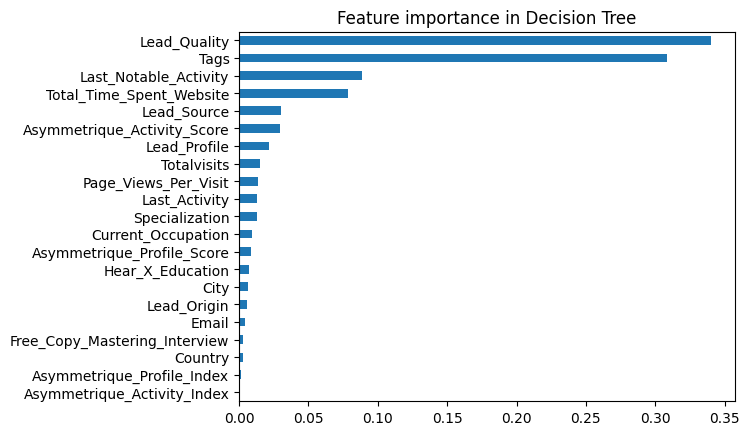

DecisionTreeClassifier(max_depth=30)

In [336]:
check_feature_importance(ls, cols=ls.columns, target='Converted', max_depth=30)

All null valued columns except Lead_Quality can be dropped. Lead_Quality has highest feature importance in deciding conversion. From business perspective Lead_Quality is the human intuition factor that is based on judicious treatment of consumer behaviour, sales experience and is an important determinant in deciding the quality of a sales prospect. This is something which cannot be modelled in a machine learning model. 

#### Null value treatment of Lead_Quality

Comparitive value count plot of object columns for nulls and non nulls of Lead_Quality

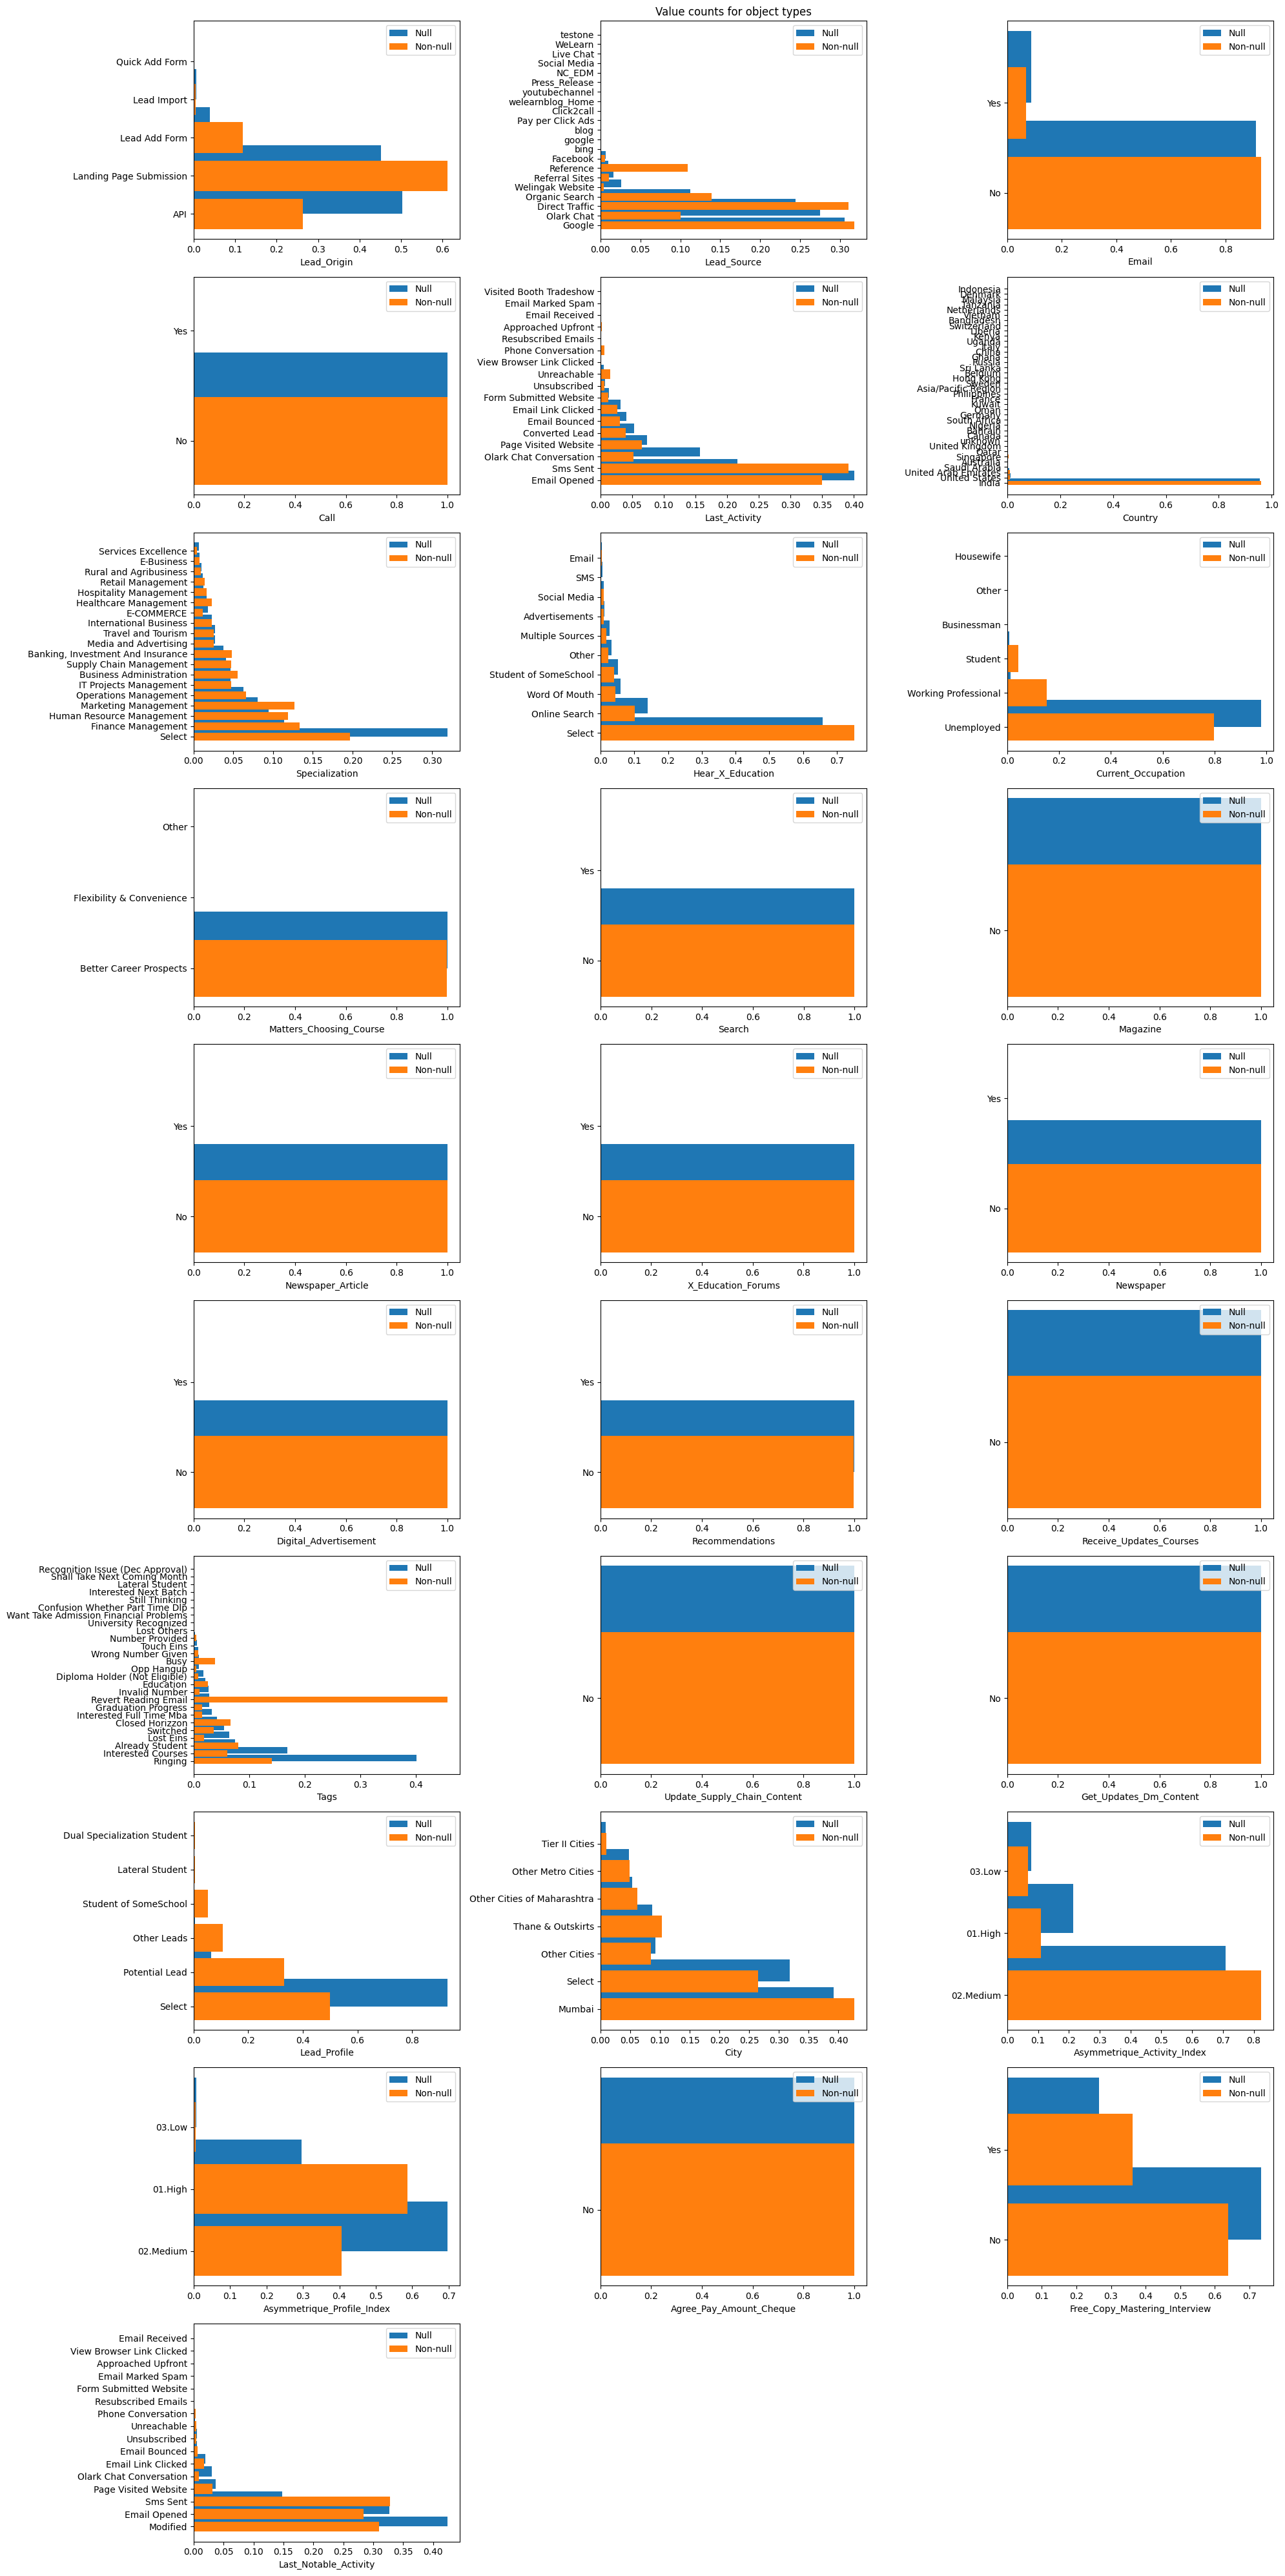

In [337]:
df1 = ls[ls.Lead_Quality.isnull()]
df2 = ls[~ls.Lead_Quality.isnull()]

value_count_plots([df1, df2], cat_cols.drop('Lead_Quality'), ['Null', 'Non-null'], [20, 40])

Comparitive histogram plots of other numeric features for null and non-nulls of Lead_Quality

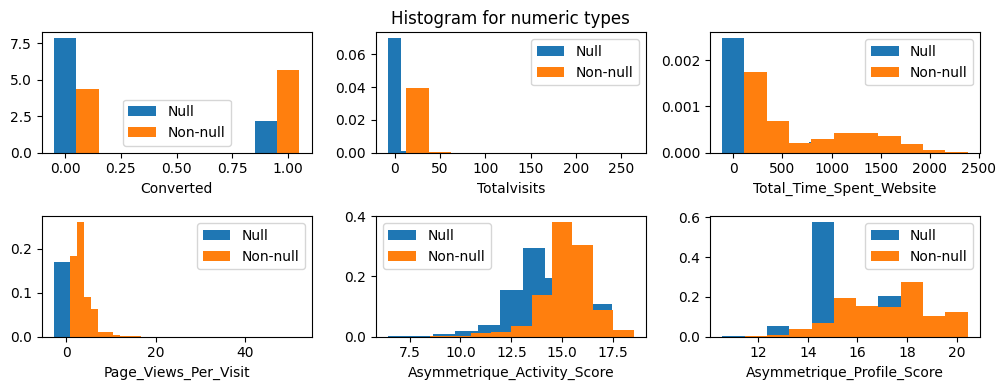

In [338]:
df1 = ls[ls.Lead_Quality.isnull()]
df2 = ls[~ls.Lead_Quality.isnull()]

histogram_plots([df1, df2], num_cols, ['Null', 'Non-null'], [10, 4])

Observations:
1. Nulls have a lower conversion than non-nulls
2. API users more nulls than non-nulls
3. Nulls use more Olark Chat than non-nulls
4. Nulls have made less course finalization on landing page than non-nulls
5. Nulls have higher non-response bias both though call and email than non-nulls

Apart from these there are no appreciable differences in patterns of nulls and non-null in Lead_Quality

Number of nulls of other features for null Lead_Quality

In [339]:
(ls[ls['Lead_Quality'].isna()].isnull().sum() / len(ls) * 100).round(2)

Lead_Origin                       0.00
Lead_Source                       0.15
Email                             0.00
Call                              0.00
Converted                         0.00
Totalvisits                       0.41
Total_Time_Spent_Website          0.00
Page_Views_Per_Visit              0.41
Last_Activity                     0.27
Country                          16.06
Specialization                   15.56
Hear_X_Education                 23.89
Current_Occupation               29.11
Matters_Choosing_Course          29.32
Search                            0.00
Magazine                          0.00
Newspaper_Article                 0.00
X_Education_Forums                0.00
Newspaper                         0.00
Digital_Advertisement             0.00
Recommendations                   0.00
Receive_Updates_Courses           0.00
Tags                             36.00
Lead_Quality                     51.59
Update_Supply_Chain_Content       0.00
Get_Updates_Dm_Content   

Null values of Lead_Quality also cover most of the null values of other features such as Country, Specialization, Tags etc. And since Lead Quality cannot be dropped, there is no other choice than to drop the records where Lead_Quality is null even if it means chopping the dataset into half. Also the null values of other features will also get eliminated

In [340]:
ls = ls[~ls['Lead_Quality'].isnull()]
fetch_nulls(ls)

,Column_name,dtype,percent_nulls
0,Lead_Source,object,0.49
1,Totalvisits,float64,2.21
2,Page_Views_Per_Visit,float64,2.21
3,Last_Activity,object,1.74
4,Country,object,21.84
5,Tags,object,0.60
6,Asymmetrique_Activity_Index,object,45.25
7,Asymmetrique_Profile_Index,object,45.25
8,Asymmetrique_Activity_Score,float64,45.25
9,Asymmetrique_Profile_Score,float64,45.25


#### Null value treatment of Country

In [341]:
ls['Country'].value_counts(normalize= True)

Country
India                   0.959668
United States           0.009153
United Arab Emirates    0.008867
Singapore               0.004291
Saudi Arabia            0.003146
United Kingdom          0.002860
Hong Kong               0.001430
Bahrain                 0.001144
France                  0.001144
Australia               0.001144
Qatar                   0.001144
Oman                    0.000858
Netherlands             0.000572
Kuwait                  0.000572
Ghana                   0.000286
Sweden                  0.000286
Nigeria                 0.000286
Germany                 0.000286
Tanzania                0.000286
Malaysia                0.000286
Uganda                  0.000286
Italy                   0.000286
Denmark                 0.000286
Canada                  0.000286
Indonesia               0.000286
South Africa            0.000286
China                   0.000286
Bangladesh              0.000286
Name: proportion, dtype: float64

Country feature can be dropped because it has a highly skewed distribution and also is very low in DecisionTree feature importance

In [342]:
ls.drop(columns='Country', inplace= True)
cat_cols = cat_cols.drop('Country')
nulls = fetch_nulls(ls)
nulls

,Column_name,dtype,percent_nulls
0,Lead_Source,object,0.49
1,Totalvisits,float64,2.21
2,Page_Views_Per_Visit,float64,2.21
3,Last_Activity,object,1.74
4,Tags,object,0.60
5,Asymmetrique_Activity_Index,object,45.25
6,Asymmetrique_Profile_Index,object,45.25
7,Asymmetrique_Activity_Score,float64,45.25
8,Asymmetrique_Profile_Score,float64,45.25


Features with less than 5% null values are filled with median for numeric types and mode for category types. As this will not adversely bias model training to a large extent

In [343]:
for col in [col for col in nulls.Column_name if 'asymmetrique' not in col.lower().split('_')]:
    if ls[col].dtype == 'O':
        ls[col].fillna(ls[col].mode()[0], inplace= True)
    else:
        ls[col].fillna(ls[col].median(), inplace= True)

fetch_nulls(ls)

,Column_name,dtype,percent_nulls
0,Asymmetrique_Activity_Index,object,45.25
1,Asymmetrique_Profile_Index,object,45.25
2,Asymmetrique_Activity_Score,float64,45.25
3,Asymmetrique_Profile_Score,float64,45.25


#### Null value treatment of Asymmetrique_Index, Asymmetrique_Score features

In [344]:
asm_cols = [col for col in ls.columns if 'asymmetrique' in col.lower().split('_')]
asm_idx = np.array([ls[ls[col].isnull()].index for col in asm_cols])    # getting the indices for asymmetrique features
asm_cols

['Asymmetrique_Activity_Index',
 'Asymmetrique_Profile_Index',
 'Asymmetrique_Activity_Score',
 'Asymmetrique_Profile_Score']

Checking unique values of Asymmetrique features

In [345]:
ls[asm_cols].apply(lambda x: x.unique())

Asymmetrique_Activity_Index                    [02.Medium, 01.High, 03.Low, nan]
Asymmetrique_Profile_Index                     [02.Medium, 01.High, 03.Low, nan]
Asymmetrique_Activity_Score    [15.0, 14.0, 13.0, 16.0, 11.0, 12.0, 9.0, 10.0...
Asymmetrique_Profile_Score     [15.0, 20.0, 17.0, 18.0, 14.0, 16.0, 13.0, 19....
dtype: object

Missing values of Asymmetrique columns have the same indices

In [346]:
# check null value indices
for i in asm_idx[1:]:
    print(np.all(asm_idx[0] == i))

True
True
True


Checking for correlation between Asymmetrique score features

In [347]:
asmScore_cols = ls[asm_cols].columns[ls[asm_cols].dtypes != 'O']
ls[asmScore_cols].corr()

,Asymmetrique_Activity_Score,Asymmetrique_Profile_Score
Asymmetrique_Activity_Score,1.000000,-0.036856
Asymmetrique_Profile_Score,-0.036856,1.000000


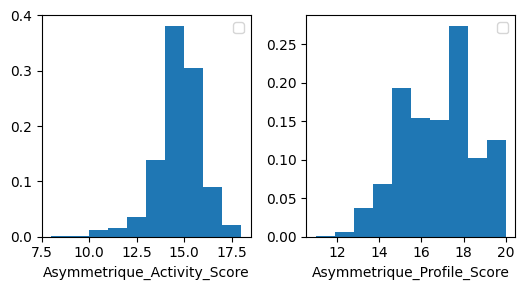

In [348]:
histogram_plots(ls, asmScore_cols, size=(8, 3))

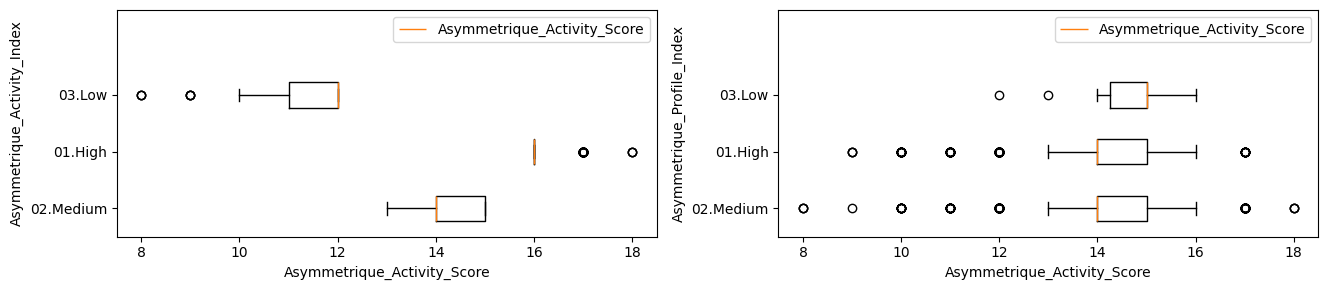

In [349]:
asmIndex_cols = ls[asm_cols].columns[ls[asm_cols].dtypes == 'O']
box_plots(ls, num_cols=['Asymmetrique_Activity_Score'], cat_cols=asmIndex_cols, vertical= False, size=(20, 3))

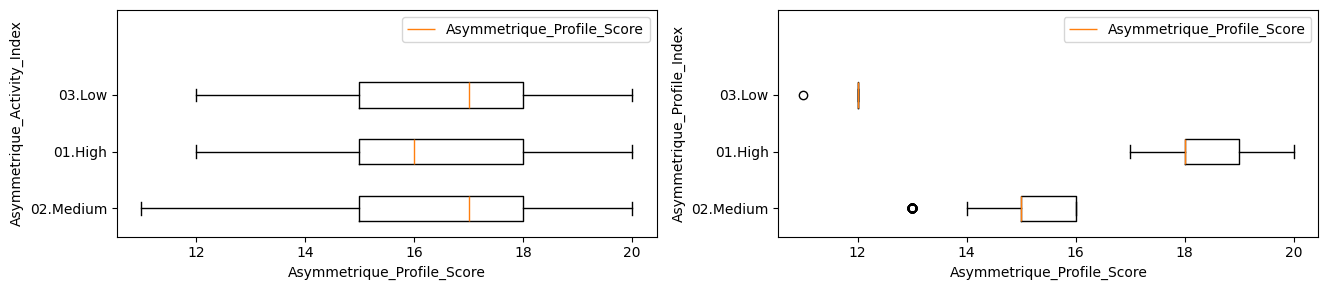

In [350]:
box_plots(ls, num_cols=['Asymmetrique_Profile_Score'], cat_cols=asmIndex_cols, vertical= False, size=(20, 3))

Observations:
1. Same records are missing for Asymmetrique indices, hence asymmetrique index values cannot be used for imputation of scores
2. Asymmetrique scores have a very weak inverse correlation between them and can be considered to be fairly independent
3. Asymmterique scores have a more or less normal distribution
4. Index features encode their respective scores

Standardized score features can be linearly combined to create a single Profile_Activity_Score (even if Profile_Score has a very low feature importance in DecisionTree). Standardization instead of Normalization retains the negative values of the scores. The Index and individual Score features can be dropped.

In [351]:
print([col for col in asmScore_cols])

['Asymmetrique_Activity_Score', 'Asymmetrique_Profile_Score']


Linear combination of standarized Activity_Score and Profile_Score

In [352]:
# Both coefficients are taken as 1 to give equal weightage to both
act_coeff = 1
prof_coeff = 1
Profile_Activity_Score = np.array([coef * (ls[col] - ls[col].mean())/ls[col].std() 
                                   for col, coef in zip(asmScore_cols, [act_coeff, prof_coeff])]).sum(axis=0)

Histogram of combined score

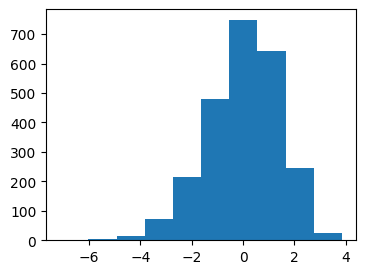

In [353]:
plt.figure(figsize=(4,3))
plt.hist(Profile_Activity_Score)
plt.show()

Boxplot of combined score

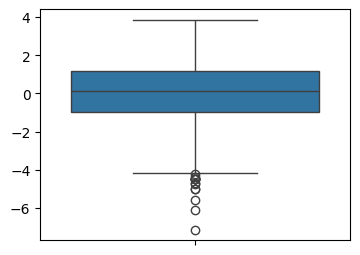

In [354]:
plt.figure(figsize= (4,3))
sns.boxplot(Profile_Activity_Score)
plt.show()

In [355]:
ls.drop(columns= asm_cols, inplace= True)
ls['Profile_Activity_Score'] = Profile_Activity_Score

Comparitive value count plot of object columns for nulls and non nulls of Profile_Activity_Score

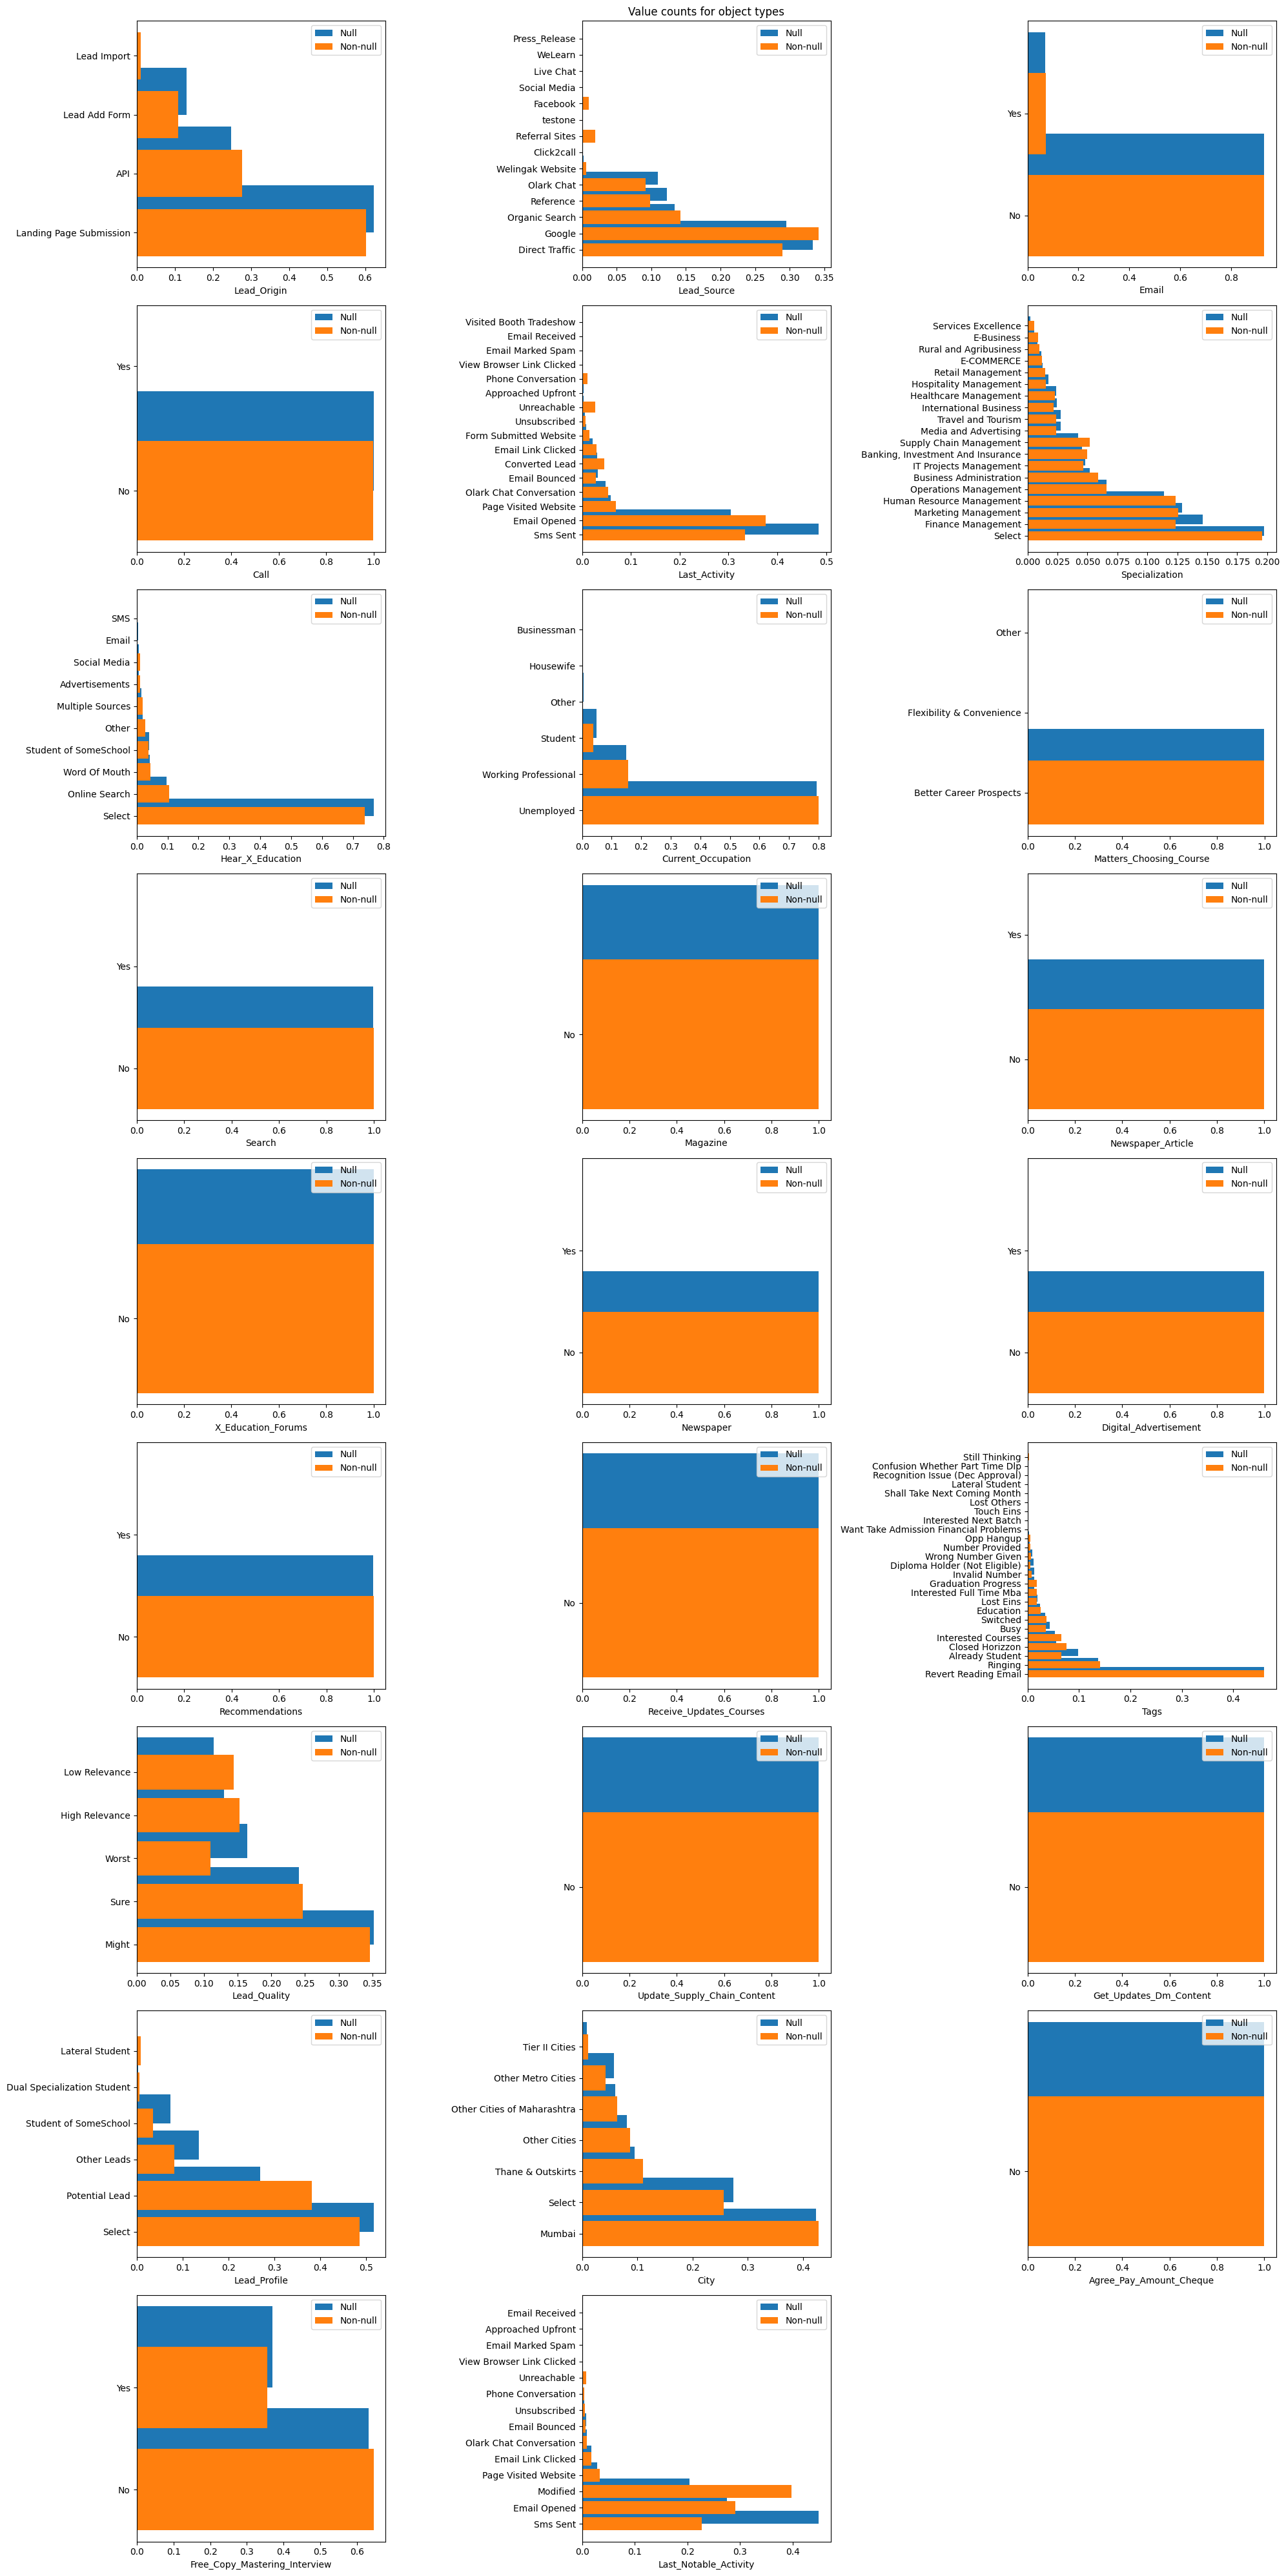

In [356]:
df1 = ls[ls.Profile_Activity_Score.isnull()]
df2 = ls[~ls.Profile_Activity_Score.isnull()]

value_count_plots([df1, df2], 
                  cat_cols.drop(['Asymmetrique_Profile_Index', 'Asymmetrique_Activity_Index']), 
                  labels=['Null', 'Non-null'], 
                  size=[20, 40])

Comparitive histogram plot of numeric columns for nulls and non nulls of Lead_Quality

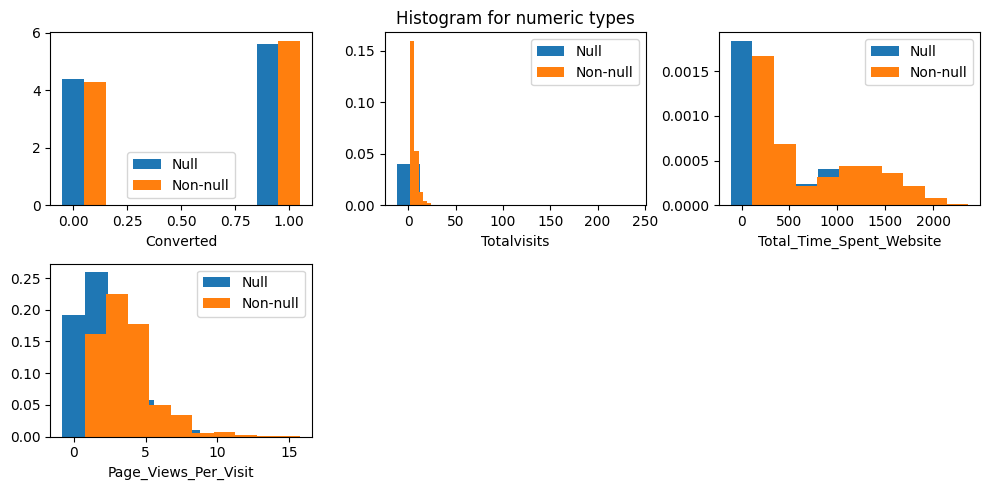

In [357]:
df1 = ls[ls.Profile_Activity_Score.isnull()]
df2 = ls[~ls.Profile_Activity_Score.isnull()]

histogram_plots([df1, df2], 
                num_cols.drop(['Asymmetrique_Profile_Score', 'Asymmetrique_Activity_Score']), 
                labels=['Null', 'Non-null'], 
                size=[10, 5])

Observations:
1. Nulls have higher SMS sent in both Last_Activity and Last_Notable_Activity than non-nulls
2. Non-ulls have a higher modified status in Last_Notable_Activity than nulls
3. Totalvisits of non-nulls have much higher webpage visits than nulls

This may indicate a data capture issue or non-response bias by the scoring algorithm

#### Predicting null values from non-null Profile_Activity_Score

Since Activity and Profile scores are generated from the dataset itself, the data for the non-null values can be used to train and predict the null values. A decision tree is used because it can work with null values in its design matrrix and it will not introduce any linearity in the dataset

Segregation of null and non_null values

In [358]:
ls_nullScore = ls[ls['Profile_Activity_Score'].isnull()]
ls_nonNullScore = ls[~ls['Profile_Activity_Score'].isnull()]

Dropping target feature Converted from prediction of nulls otherwise it will bias final model training through back-propagation of values

In [359]:
ls_nullScore.drop(columns='Converted', inplace= True)
ls_nonNullScore.drop(columns='Converted', inplace= True)

Feature importance in prediction of non-null Profile_Activity_Score

Model accuracy score =  0.9963787274959232


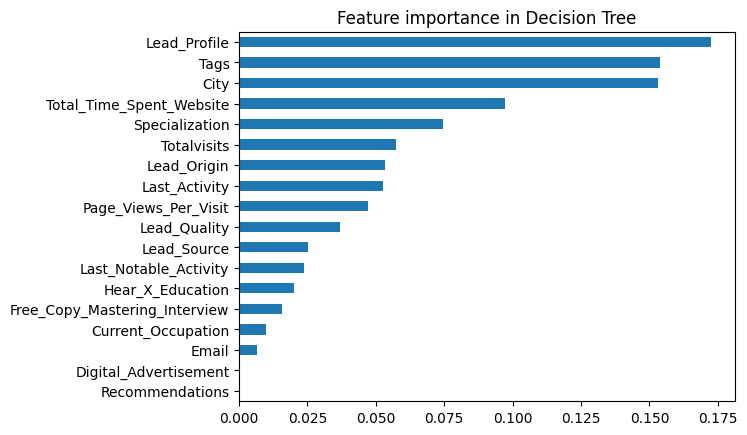

DecisionTreeRegressor(max_depth=30)

In [360]:
check_feature_importance(ls_nonNullScore, 
                        cols=ls_nonNullScore.columns, 
                        target='Profile_Activity_Score', 
                        discrete_target= False, max_depth=30)

Using GridSearchCV to predict results

In [361]:
encoder = OrdinalEncoder()
ls_nonNullScore[ls_nonNullScore.columns[ls_nonNullScore.dtypes == 'O']] = encoder.fit_transform(ls_nonNullScore[ls_nonNullScore.columns[ls_nonNullScore.dtypes == 'O']])

X = ls_nonNullScore.drop(columns= 'Profile_Activity_Score')
y = ls_nonNullScore['Profile_Activity_Score']

dt= DecisionTreeRegressor(criterion='squared_error')
params = {
    'max_depth': np.arange(2, 21),
    'min_samples_leaf': np.arange(2, 11),
    }
grid = GridSearchCV(estimator= dt, param_grid= params, cv= 3, n_jobs= -1)
grid.fit(X, y)

pd.DataFrame(grid.cv_results_).sort_values(by= 'rank_test_score')[:3]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
31,0.005100,8.282145e-04,0.000649,0.000520,5,6,"{'max_depth': 5, 'min_samples_leaf': 6}",0.449979,0.331007,0.250279,0.343755,0.082024,1
33,0.003301,9.587794e-04,0.000668,0.000945,5,8,"{'max_depth': 5, 'min_samples_leaf': 8}",0.435434,0.342099,0.247299,0.341611,0.076807,2
30,0.004008,1.123916e-07,0.001760,0.000345,5,5,"{'max_depth': 5, 'min_samples_leaf': 5}",0.438950,0.332143,0.250870,0.340654,0.077019,3


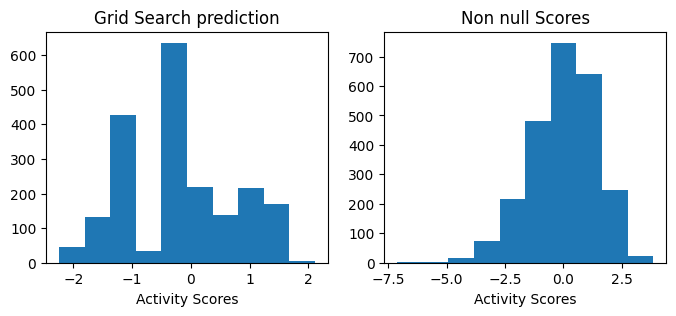

In [362]:
# encoding object types for nulls
encoder = OrdinalEncoder()
ls_nullScore[ls_nullScore.columns[ls_nullScore.dtypes == 'O']] = encoder.fit_transform(ls_nullScore[ls_nullScore.columns[ls_nullScore.dtypes == 'O']])
X = ls_nullScore.drop(columns= 'Profile_Activity_Score')

null_scores_grid = grid.best_estimator_.predict(X)   # gridsearch model

# plotting distributions
plt.figure(figsize=(8, 3))
ax2 = plt.subplot(1, 2, 1)
ax2.hist(null_scores_grid)
ax2.set_xlabel('Activity Scores')
ax2.set_title('Grid Search prediction')

ax3 = plt.subplot(1, 2, 2)
ax3.hist(ls_nonNullScore['Profile_Activity_Score'])
ax3.set_xlabel('Activity Scores')
ax3.set_title('Non null Scores')
plt.show()

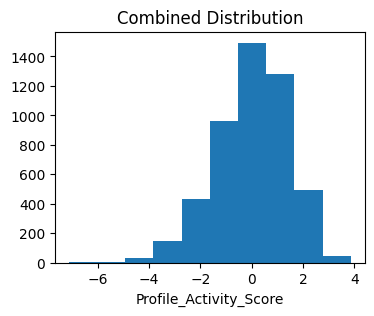

In [363]:
plt.figure(figsize= (4, 3))
plt.hist(np.concatenate([y, ls_nonNullScore['Profile_Activity_Score']]))
plt.xlabel('Profile_Activity_Score')
plt.title('Combined Distribution')
plt.show()

In [364]:
ls.loc[ls['Profile_Activity_Score'].isnull(), 'Profile_Activity_Score'] = null_scores_grid

In [365]:
fetch_nulls(ls)

,Column_name,dtype,percent_nulls


Summary info of null removed dataset

In [366]:
ls.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4473 entries, 0 to 9239
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Lead_Origin                    4473 non-null   object 
 1   Lead_Source                    4473 non-null   object 
 2   Email                          4473 non-null   object 
 3   Call                           4473 non-null   object 
 4   Converted                      4473 non-null   int64  
 5   Totalvisits                    4473 non-null   float64
 6   Total_Time_Spent_Website       4473 non-null   int64  
 7   Page_Views_Per_Visit           4473 non-null   float64
 8   Last_Activity                  4473 non-null   object 
 9   Specialization                 4473 non-null   object 
 10  Hear_X_Education               4473 non-null   object 
 11  Current_Occupation             4473 non-null   object 
 12  Matters_Choosing_Course        4473 non-null   object

Feature segregation based on data types

In [367]:
cat_cols = ls.columns[ls.dtypes == 'O']
num_cols = ls.columns[ls.dtypes != 'O']
print('Number of category features: ', len(cat_cols))
print(cat_cols.tolist())
print('Number of numeric features: ', len(num_cols))
print(num_cols.tolist())

Number of category features:  26
['Lead_Origin', 'Lead_Source', 'Email', 'Call', 'Last_Activity', 'Specialization', 'Hear_X_Education', 'Current_Occupation', 'Matters_Choosing_Course', 'Search', 'Magazine', 'Newspaper_Article', 'X_Education_Forums', 'Newspaper', 'Digital_Advertisement', 'Recommendations', 'Receive_Updates_Courses', 'Tags', 'Lead_Quality', 'Update_Supply_Chain_Content', 'Get_Updates_Dm_Content', 'Lead_Profile', 'City', 'Agree_Pay_Amount_Cheque', 'Free_Copy_Mastering_Interview', 'Last_Notable_Activity']
Number of numeric features:  5
['Converted', 'Totalvisits', 'Total_Time_Spent_Website', 'Page_Views_Per_Visit', 'Profile_Activity_Score']


### Exploratory data analysis: Univariate analysis

#### Category features

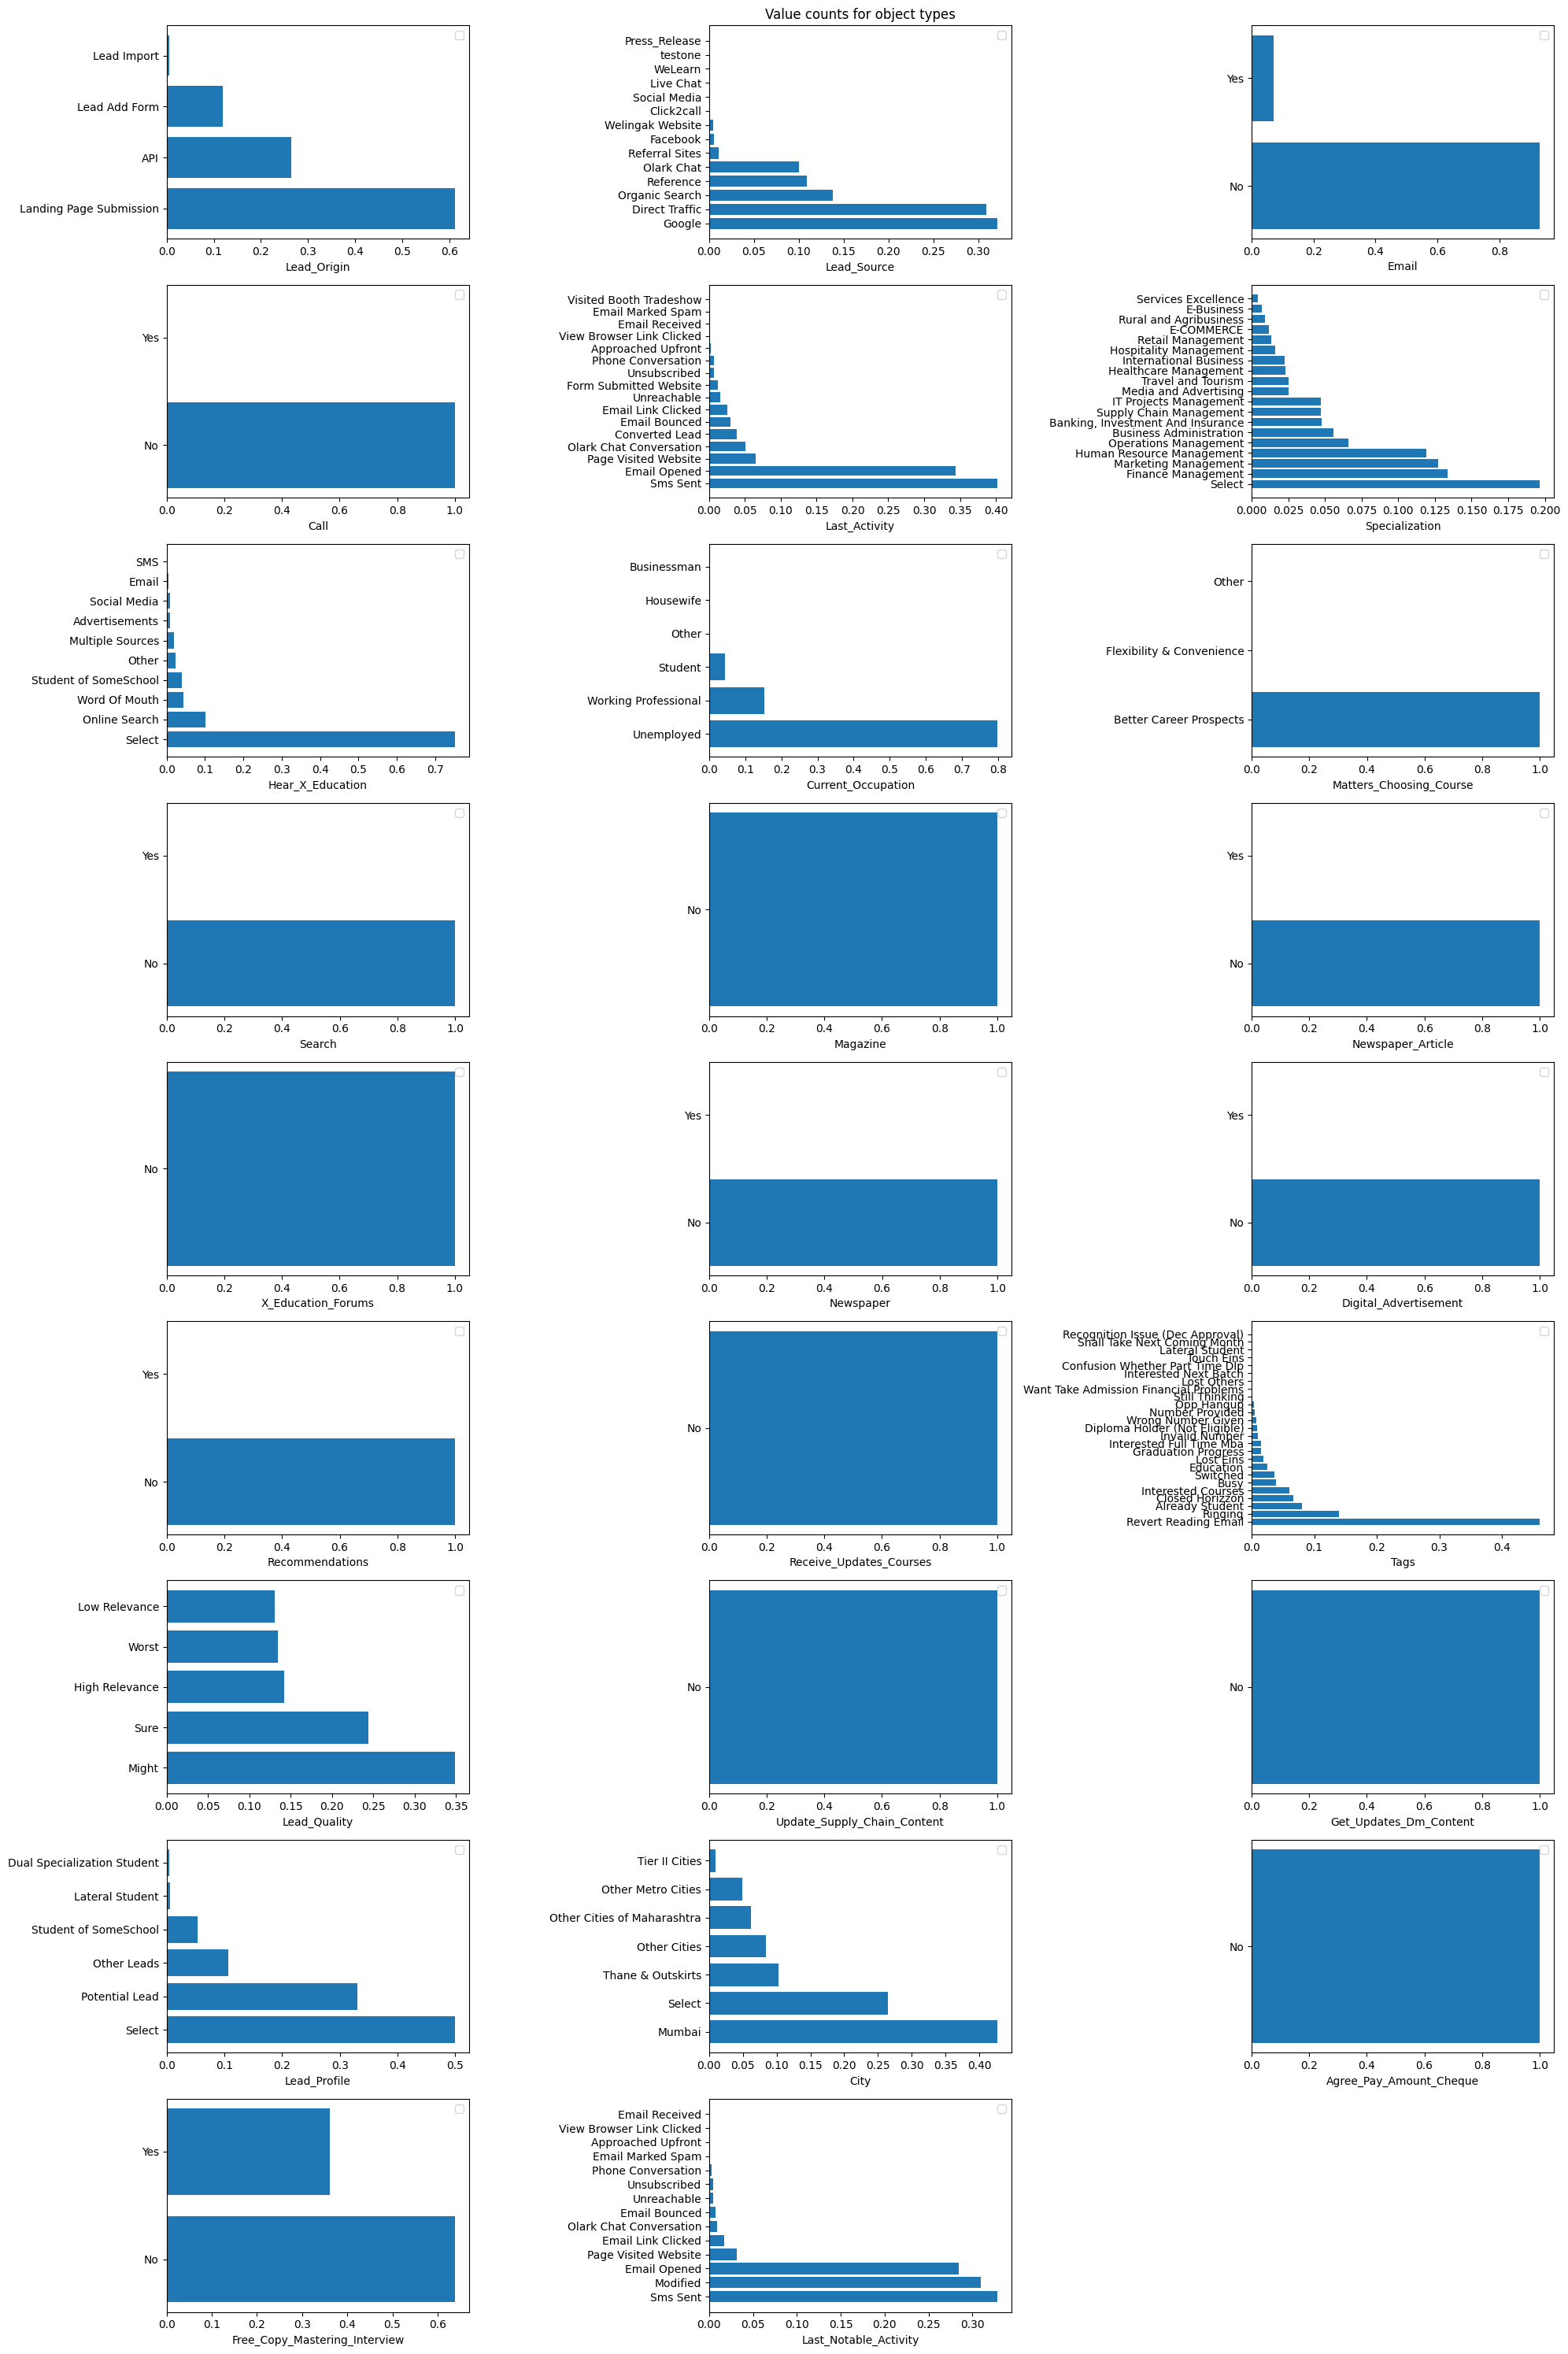

In [368]:
value_count_plots(ls, cat_cols, size=(20, 30), ncols=3)

Columns that have only a single value

1. Magazine
2. X_Education_forum
3. Receive_Update_Courses
4. Update_Supply_Chain_Content
5. Get_Updates_Dm_Content
6. Agree_Pay_Amount_Cheque

These can be discarded from further analysis because they will not contribute to model training

In [369]:
oneval_cols = ls[cat_cols].columns[ls[cat_cols].apply(lambda x: x.nunique()) == 1]

Dropping columns

In [370]:
ls.drop(columns= oneval_cols, inplace= True)
cat_cols = cat_cols.drop(oneval_cols)

#### Numeric features

Descriptive statistics of numeric features

In [371]:
ls[num_cols].describe()

,Converted,Totalvisits,Total_Time_Spent_Website,Page_Views_Per_Visit,Profile_Activity_Score
count,4473.000000,4473.000000,4473.000000,4473.000000,4473.000000
mean,0.567181,3.774201,600.523362,2.586175,-0.099638
std,0.495522,5.231235,581.525926,2.060504,1.218129
min,0.000000,0.000000,0.000000,0.000000,-7.125748
25%,0.000000,2.000000,67.000000,1.330000,-1.191872
50%,1.000000,3.000000,358.000000,2.000000,-0.269471
75%,1.000000,5.000000,1113.000000,4.000000,0.889947
max,1.000000,251.000000,2272.000000,16.000000,3.856885


Spread of values of numeric features

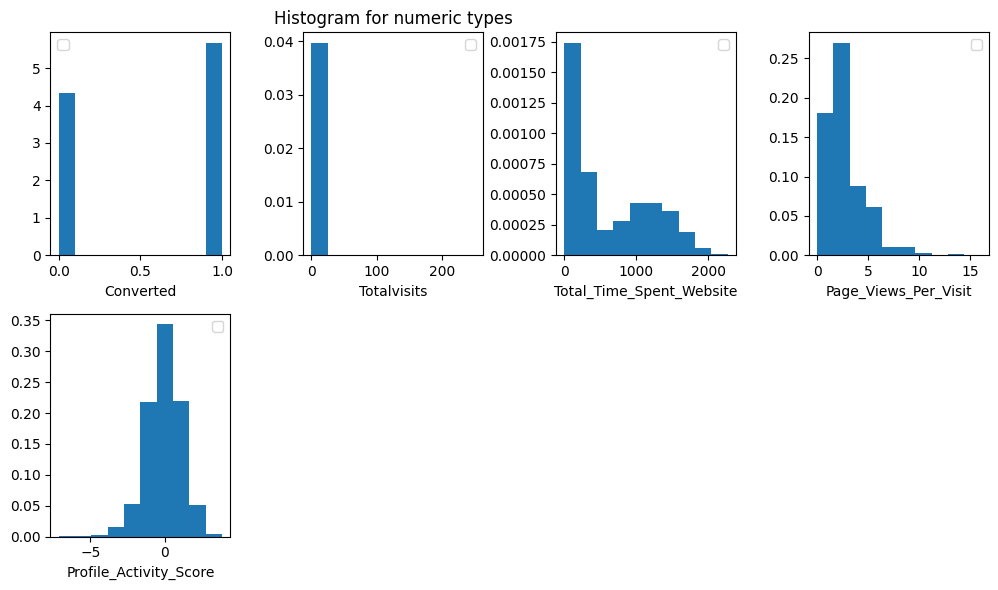

In [372]:
histogram_plots(ls, num_cols, size=(10, 6), ncols= 4)

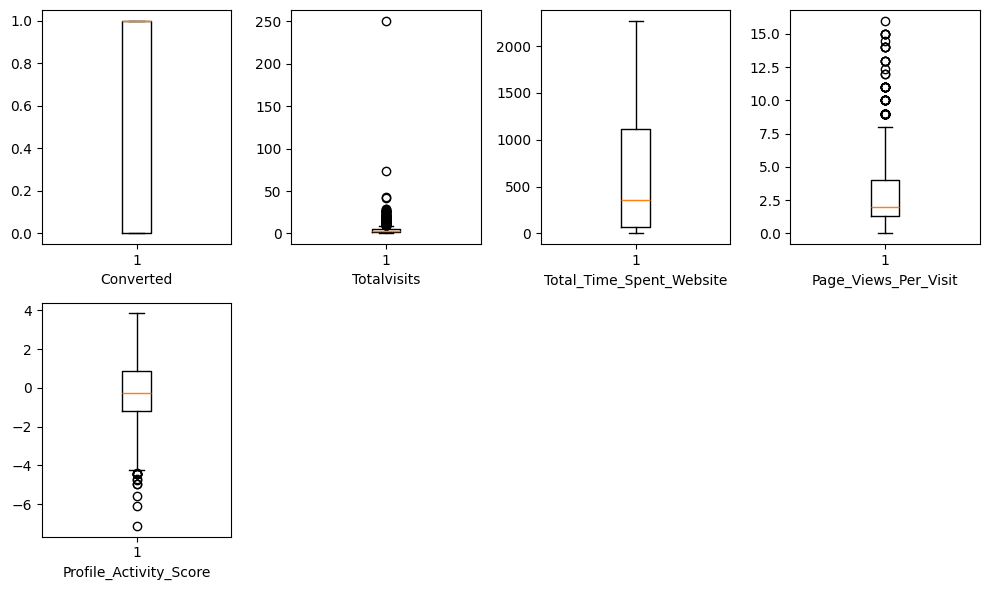

In [373]:
box_plots(ls, num_cols, size=(10, 6), ncols= 4)

Totalvisits and Page_Views_Per_Visit have outliers. Checking frequency spread of these features for higher percentiles

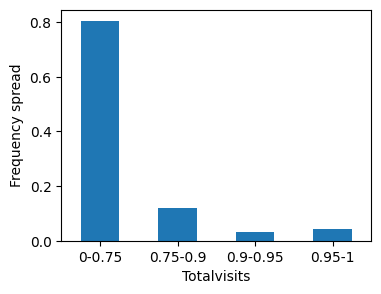

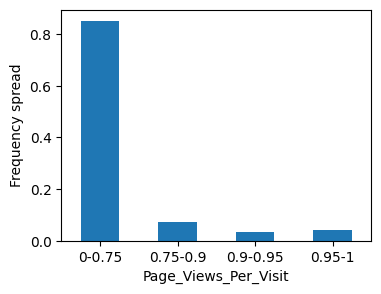

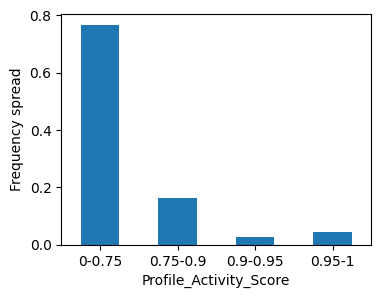

In [374]:
for col in ['Totalvisits', 'Page_Views_Per_Visit', 'Profile_Activity_Score']:
    plt.figure(figsize=(4,3))
    pd.qcut(ls[col], q=[0, 0.75, 0.9, 0.95, 1], 
            labels=['0-0.75', '0.75-0.9', '0.9-0.95', '0.95-1']).value_counts(normalize= True).sort_index().plot.bar()
    plt.xlabel(col)
    plt.xticks(rotation=0)
    plt.ylabel('Frequency spread')
    plt.show()

A weight-of-evidence logarithmic transformation will eliminate outliers and linearize the spread of values for Totalvisits and Page_Views_Per_Visit

### Exploratory data analysis: Bivariate analysis

#### Category features

Spread of target feature over unique values across all category features

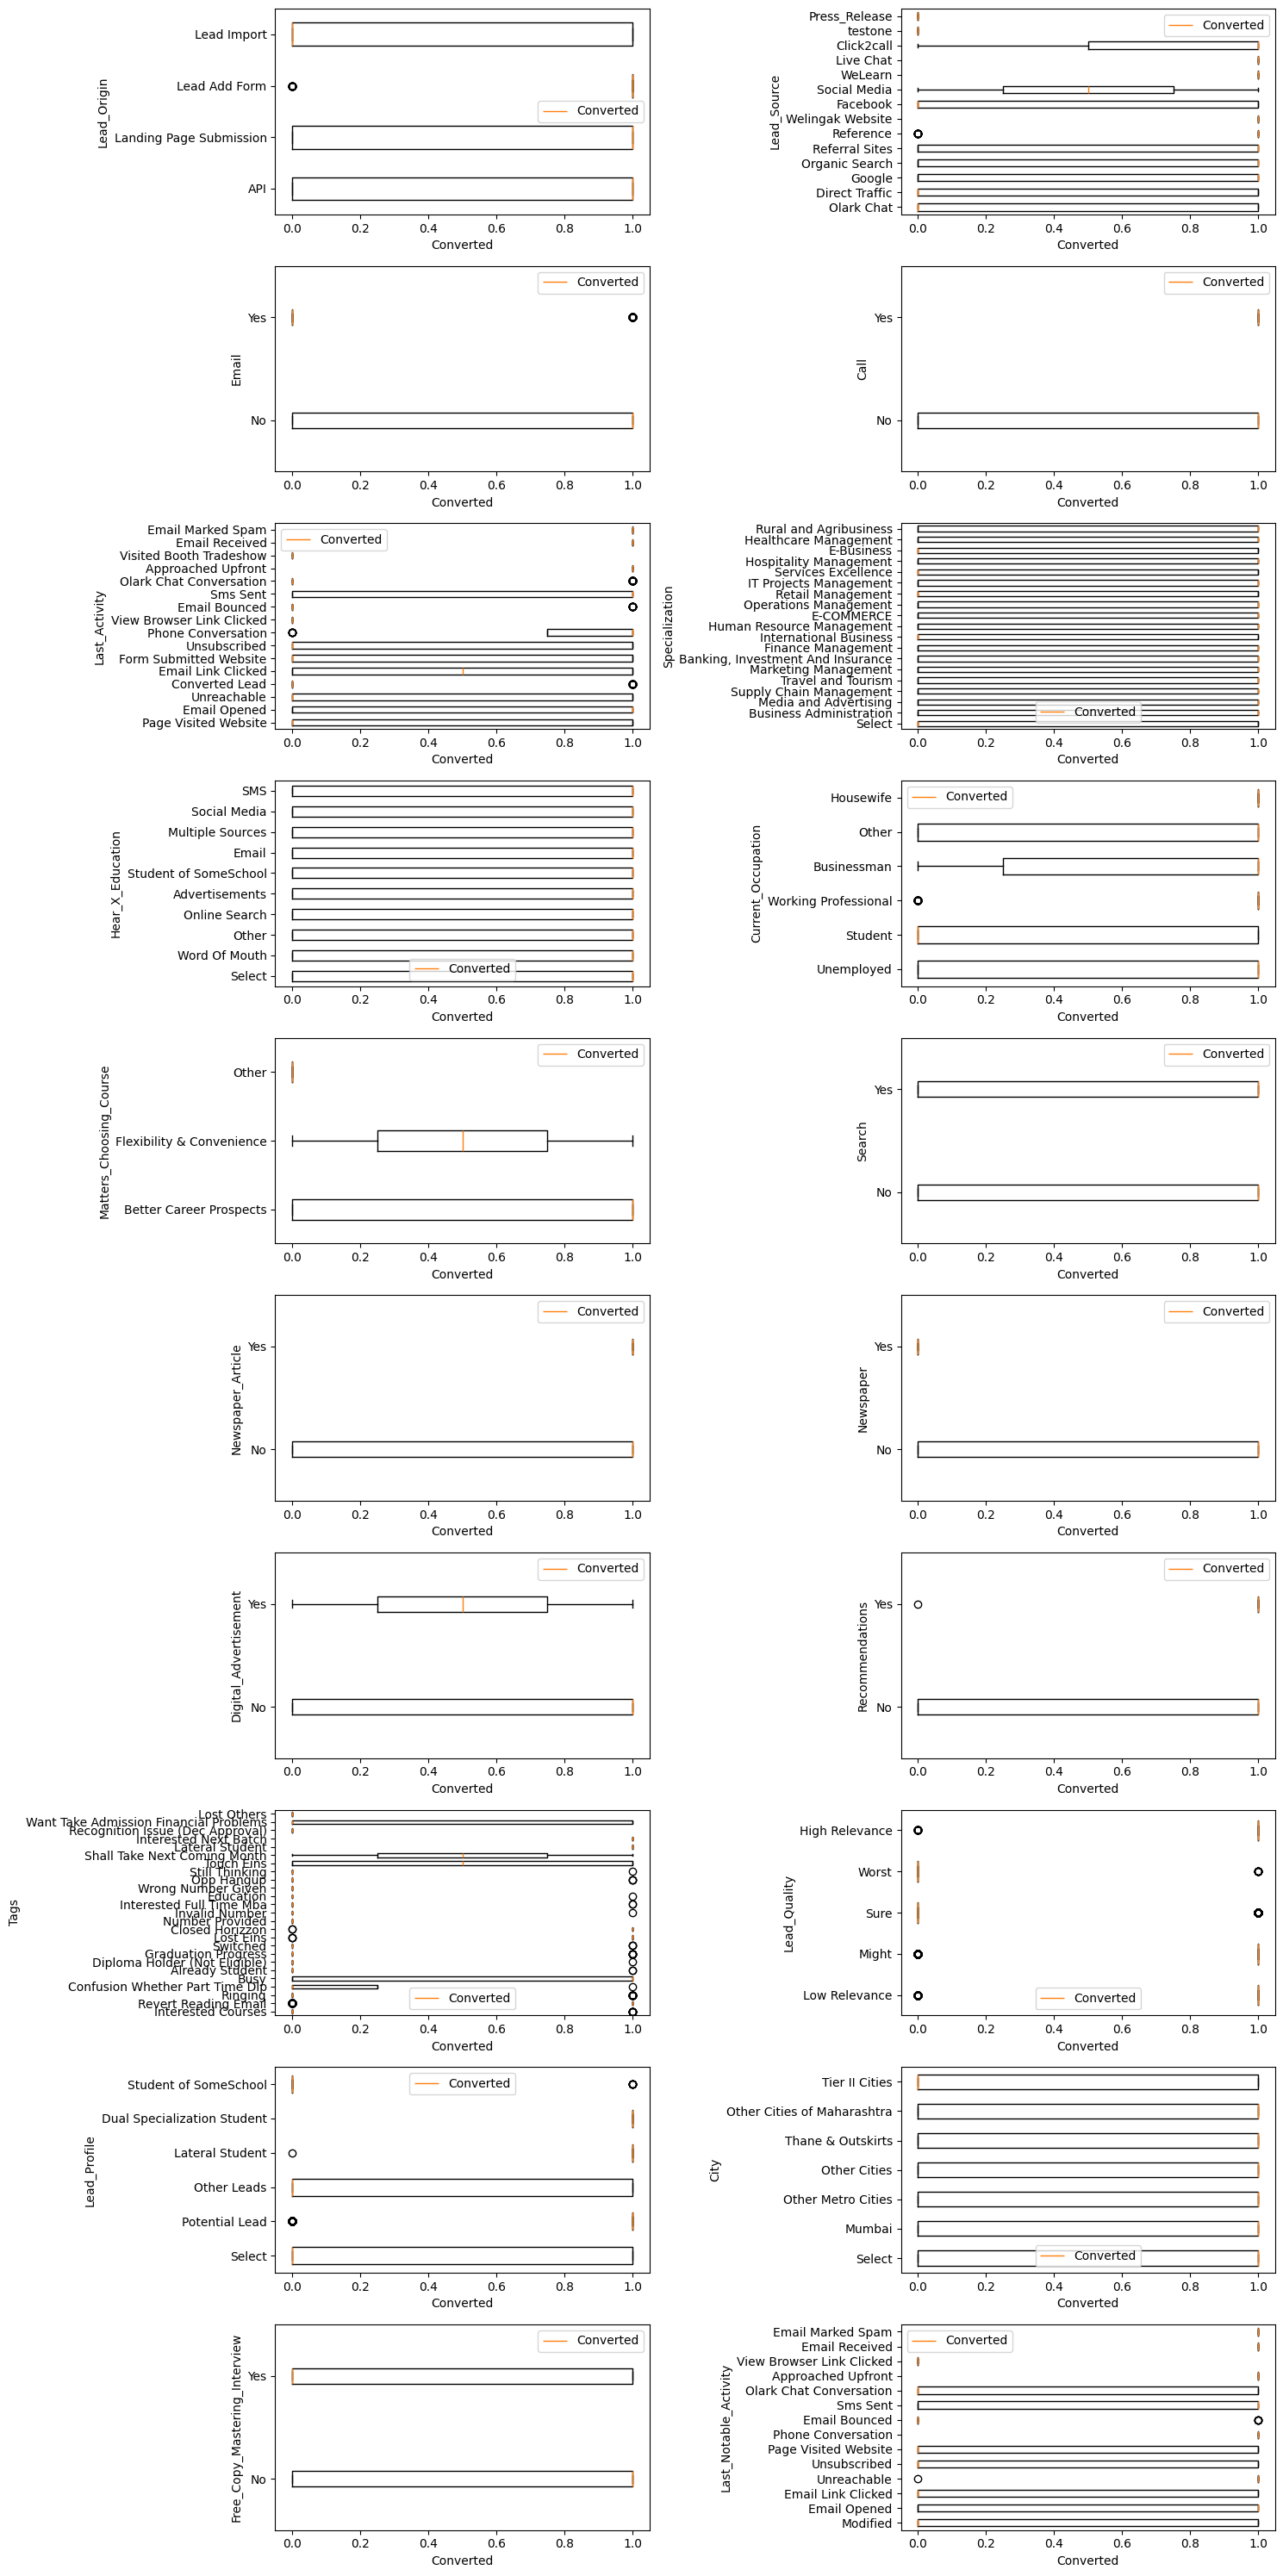

In [375]:
box_plots(ls, num_cols=['Converted'], cat_cols= cat_cols, size=(15, 30), ncols= 2, vertical=False)

### Trial models